In [1]:
#!/usr/bin/env python3
# --------------------------------------------------------------
# Author: Mahendra Data - mahendra.data@dbms.cs.kumamoto-u.ac.jp
# License: BSD 3 clause
# --------------------------------------------------------------

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi

Wed Aug 12 07:32:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras

from tensorflow.keras.utils import plot_model

In [5]:
# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))


In [7]:
PROCESSED_DIR_PATH = "/content/drive/My Drive/CICIDS2017/ProcessedDataset"
MODEL_DIR_PATH = "/content/drive/My Drive/CICIDS2017/Model"

In [8]:
def create_dense_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(78, ))
    x = keras.layers.Dense(128, activation='relu')(inputs)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    dense_model = keras.Model(inputs=inputs, outputs=outputs)

    dense_model.compile(loss='sparse_categorical_crossentropy',
                        metrics=['sparse_categorical_accuracy'],
                        optimizer='adam')

    return dense_model

In [9]:
# Create model
model = create_dense_model()
logging.info(model.summary())

07:33:08 INFO None


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 78)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               10112     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                495       
Total params: 20,943
Trainable params: 20,943
Non-trainable params: 0
_________________________________________________________________


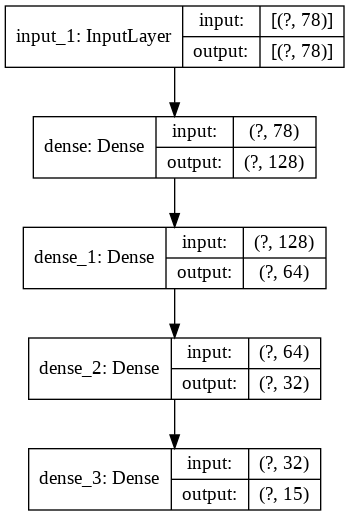

In [10]:
plot_model(model, show_shapes=True)

In [11]:
# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

07:33:29 INFO Class distribution
0     1818477
4      184858
10     127144
2      102421
3        8234
7        6350
11       4718
6        4637
5        4399
1        1573
12       1206
14        522
9          29
13         17
8           9
Name: Label, dtype: int64


In [12]:
X, y = preprocessing(df)
del df

In [13]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, y, validation_split=0.1, epochs=125, batch_size=1024, verbose=True)

07:33:34 INFO *** TRAINING START ***


Epoch 1/125
1991/1991 [==============================] - 8s 4ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.0694 - val_sparse_categorical_accuracy: 0.9715
Epoch 2/125
1991/1991 [==============================] - 8s 4ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9816
Epoch 3/125
1991/1991 [==============================] - 8s 4ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.0435 - val_sparse_categorical_accuracy: 0.9819
Epoch 4/125
1991/1991 [==============================] - 9s 4ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9840 - val_loss: 0.0342 - val_sparse_categorical_accuracy: 0.9870
Epoch 5/125
1991/1991 [==============================] - 8s 4ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0338 - val_sparse_categorical_accuracy: 0.9867
Epoch 6/125
1991/1991 [==============================] - 8s 4ms/step - loss: 0.0323 -

In [14]:
logging.info("*** TRAINING FINISH ***")
del X, y

07:50:52 INFO *** TRAINING FINISH ***


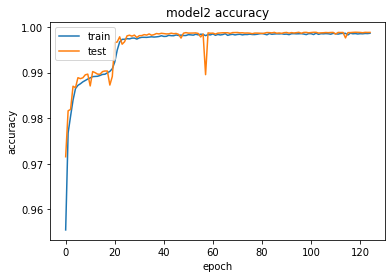

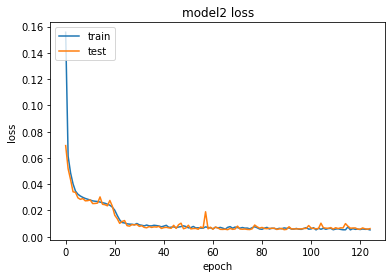

In [15]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "05_dense.h5"))

plot_history(history)

In [16]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

07:51:17 INFO Class distribution
0     1818477
4      184858
10     127144
2      102421
3        8234
7        6350
11       4718
6        4637
5        4399
1        1573
12       1206
14        522
9          29
13         17
8           9
Name: Label, dtype: int64


In [17]:
X, y = preprocessing(df)
del df

In [18]:
evaluation(model, X, y)
del X, y

07:53:18 INFO Evaluation:
Loss: 0.00502212718129158
Accuracy : 0.998765766620636

07:53:24 INFO 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1818477
           1       1.00      0.38      0.55      1573
           2       1.00      1.00      1.00    102421
           3       1.00      1.00      1.00      8234
           4       1.00      1.00      1.00    184858
           5       0.98      0.99      0.99      4399
           6       1.00      0.99      0.99      4637
           7       1.00      1.00      1.00      6350
           8       1.00      1.00      1.00         9
           9       0.96      0.76      0.85        29
          10       0.99      1.00      1.00    127144
          11       0.99      0.98      0.98      4718
          12       0.70      0.99      0.82      1206
          13       0.57      0.24      0.33        17
          14       1.00      0.05      0.10       522

    accuracy                         

In [19]:
logging.info("*** END ***")

07:53:24 INFO *** END ***
